In [231]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB


In [232]:
# Replace 'data.csv' with your actual dataset path
df = pd.read_csv('data.csv')

In [233]:
df.head()

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    863 non-null    int64  
 1   location      863 non-null    int64  
 2   country       863 non-null    int64  
 3   gender        863 non-null    int64  
 4   age           863 non-null    float64
 5   vis_wuhan     863 non-null    int64  
 6   from_wuhan    863 non-null    int64  
 7   symptom1      863 non-null    int64  
 8   symptom2      863 non-null    int64  
 9   symptom3      863 non-null    int64  
 10  symptom4      863 non-null    int64  
 11  symptom5      863 non-null    int64  
 12  symptom6      863 non-null    int64  
 13  diff_sym_hos  863 non-null    int64  
 14  result        863 non-null    int64  
dtypes: float64(1), int64(14)
memory usage: 101.3 KB


In [235]:
df.isna().sum()

,0
Unnamed: 0,0
location,0
country,0
gender,0
age,0
vis_wuhan,0
from_wuhan,0
symptom1,0
symptom2,0
symptom3,0


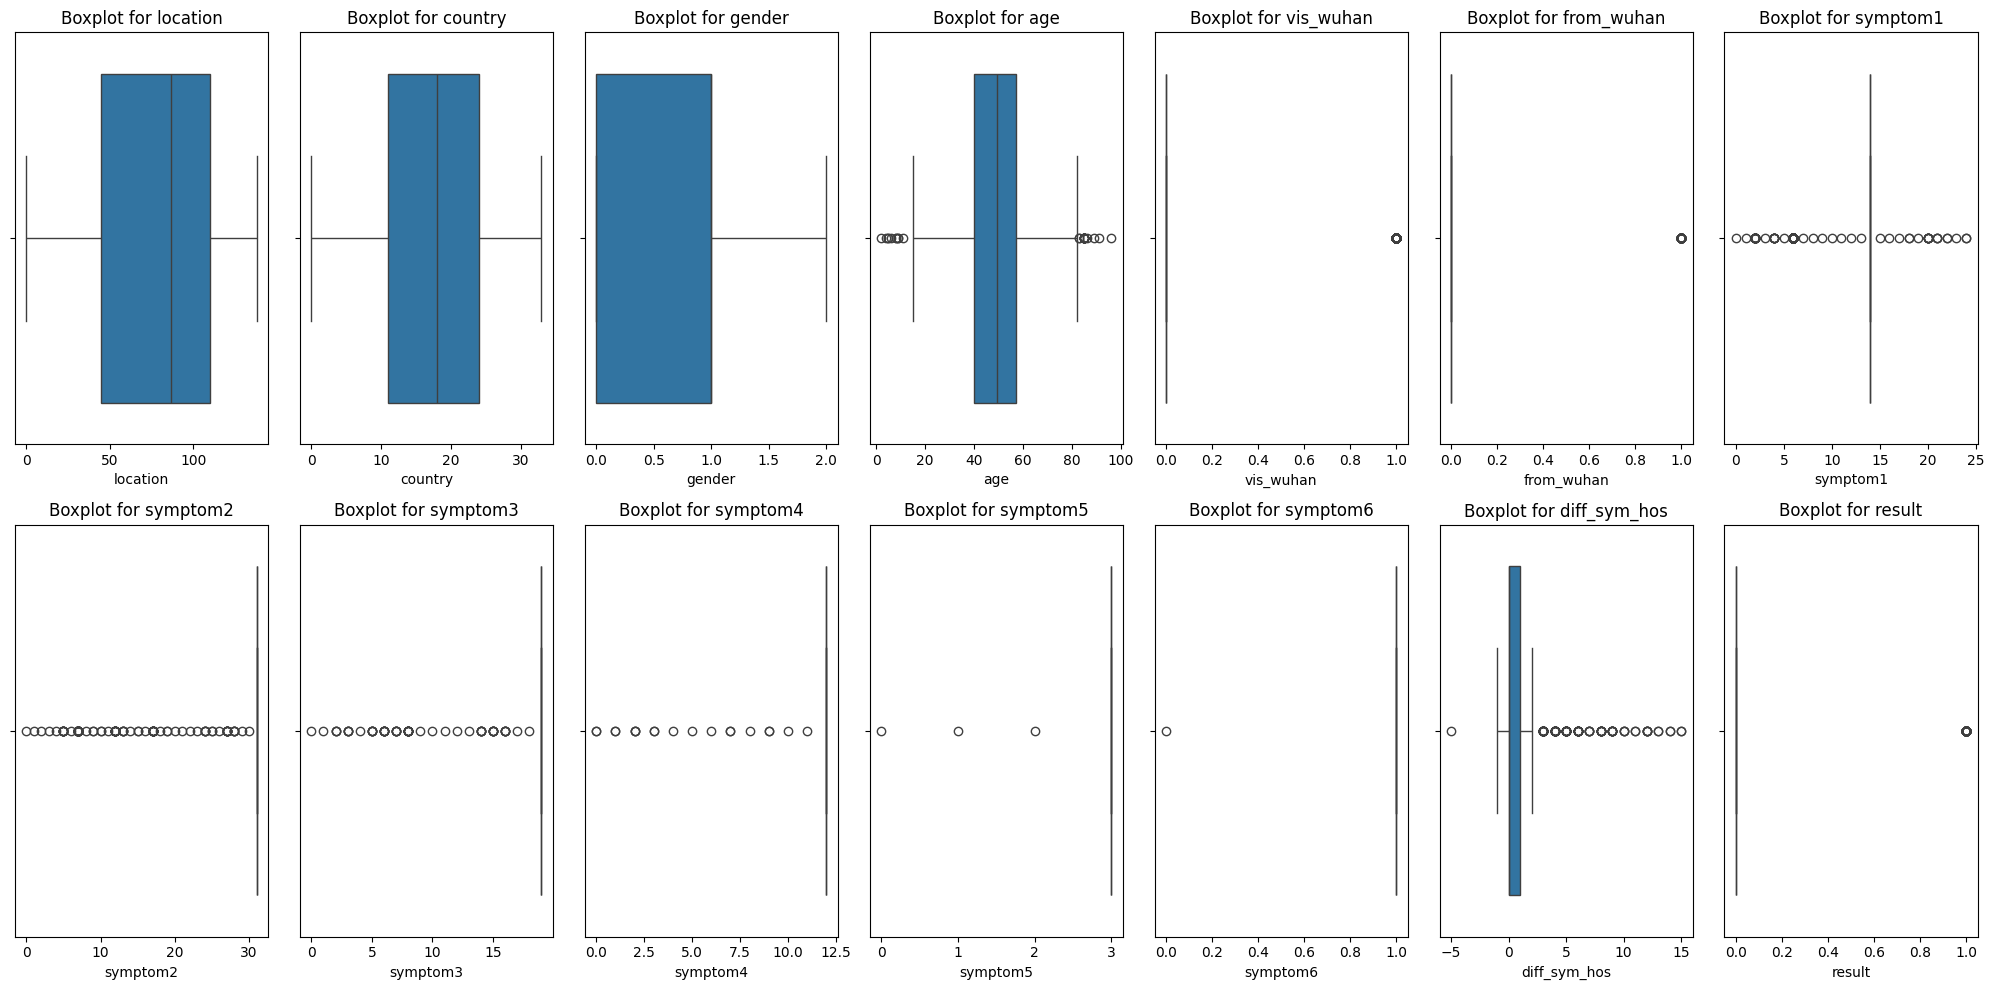

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt


df_filtered = df.loc[:, ~df.columns.str.contains('^Unnamed')]
columns = df_filtered.columns

n_cols = 7
n_rows = (len(columns) + n_cols - 1) // n_cols

# Create a subplot with the necessary number of rows and columns
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5 * n_rows))

axes = axes.flatten()

# Loop through each column to plot boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=df_filtered[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')
    axes[i].set_xlabel(column)

plt.tight_layout()
plt.show()


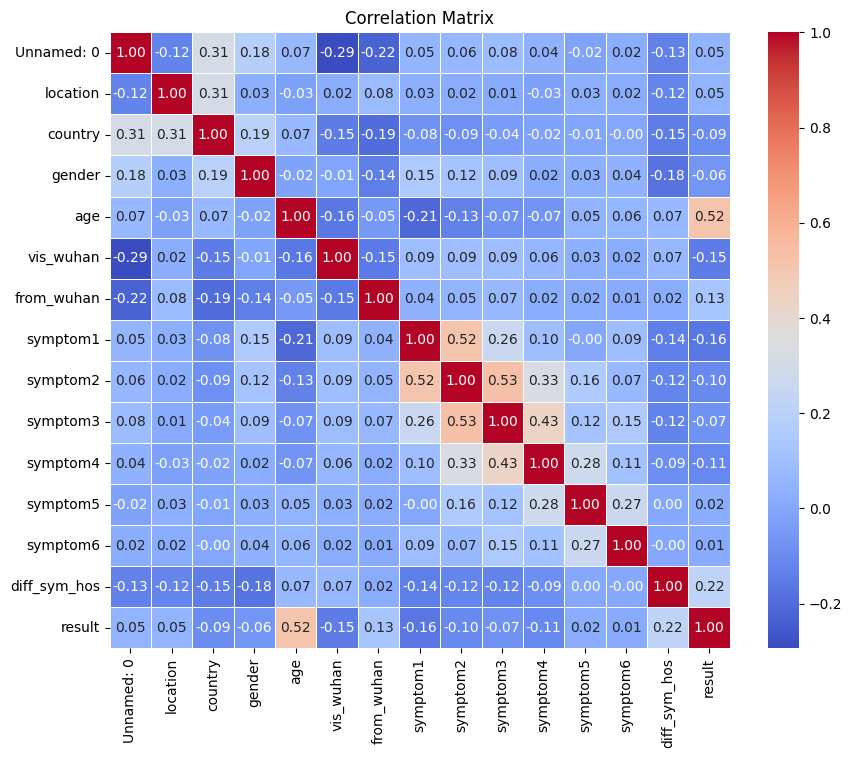

In [237]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


array([[<Axes: title={'center': 'age'}>]], dtype=object)

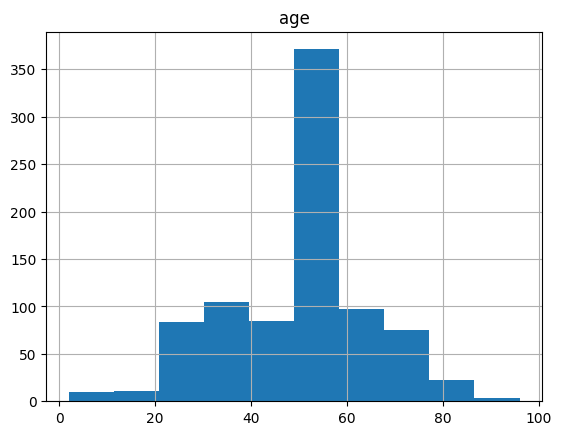

In [238]:
#Checking the range of age of the people we have in the dataset
df.hist(column='age')

In [239]:
df = df.drop(columns=[ 'symptom6','Unnamed: 0','symptom5'])

In [240]:
df['result'].value_counts()

,count
result,
0,755
1,108


<ipython-input-241-ac6560ee321a>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='result', data=df, palette='viridis')


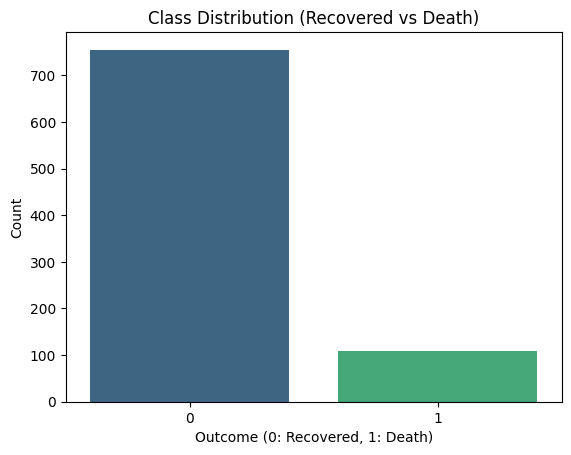

In [241]:
sns.countplot(x='result', data=df, palette='viridis')
plt.title('Class Distribution (Recovered vs Death)')
plt.xlabel('Outcome (0: Recovered, 1: Death)')
plt.ylabel('Count')
plt.show()

In [242]:
X = df.drop('result', axis=1)
y = df['result']


In [243]:
# Split data: 60% training, 20% validation, 20% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [244]:
# balance data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print('Origianl dataset shape:', Counter(y_train))
print('Balanced dataset shape:', Counter(y_train_resampled))

Origianl dataset shape: Counter({0: 452, 1: 65})
Balanced dataset shape: Counter({0: 452, 1: 452})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


**K_Nearest Neighbours**

In [245]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_resampled, y_train_resampled)

best_knn = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)



Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [246]:
# Predict on the validation set
y_val_pred = best_knn.predict(X_val)
y_val_prob = best_knn.predict_proba(X_val)[:, 1]  # Probability estimates

# Classification report and confusion matrix
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_val, y_val_prob)
print(f"AUC-ROC Score: {roc_auc}")


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       151
           1       0.83      0.86      0.84        22

    accuracy                           0.96       173
   macro avg       0.90      0.92      0.91       173
weighted avg       0.96      0.96      0.96       173

Confusion Matrix:
[[147   4]
 [  3  19]]
AUC-ROC Score: 0.9169175195665262


Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       152
           1       0.75      0.86      0.80        21

    accuracy                           0.95       173
   macro avg       0.86      0.91      0.89       173
weighted avg       0.95      0.95      0.95       173

Confusion Matrix:
[[146   6]
 [  3  18]]
Test AUC-ROC Score: 0.9288847117794486


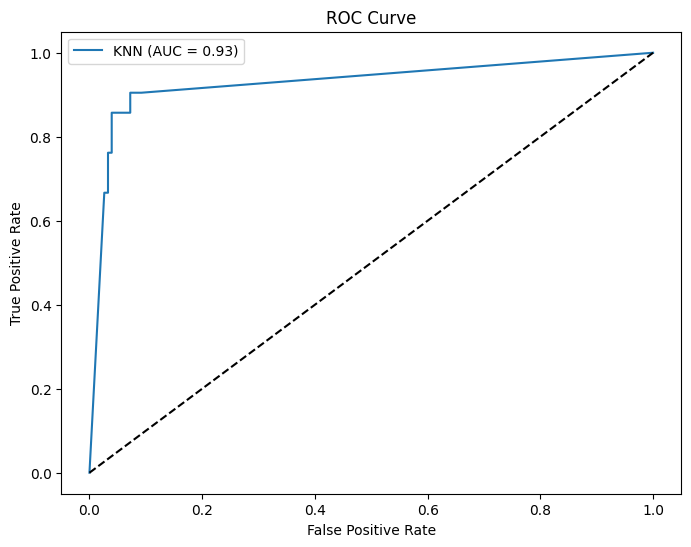

In [247]:
# Predict on the test set
y_test_pred = best_knn.predict(X_test)
y_test_prob = best_knn.predict_proba(X_test)[:, 1]

# Classification report and AUC-ROC score
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


test_roc_auc = roc_auc_score(y_test, y_test_prob)
print(f"Test AUC-ROC Score: {test_roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"KNN (AUC = {test_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


**Logistic Regression**

In [248]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Initialize logistic regression
log_reg = LogisticRegression(random_state=42, max_iter=10000)  # Added max_iter for convergence

# Define the parameter grid
param_grid = [
    {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}  # liblinear is a good choice for 'l1' and 'l2'
    # You can uncomment the following block if using 'elasticnet' penalty and 'saga' solver
    # {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10], 'solver': ['saga'], 'l1_ratio': [0.5]}
]

# Perform grid search
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall', error_score='raise')
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model and parameters
best_log_reg = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [249]:
y_val_pred = best_log_reg.predict(X_val)
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.99      0.93      0.96       151
           1       0.67      0.91      0.77        22

    accuracy                           0.93       173
   macro avg       0.83      0.92      0.86       173
weighted avg       0.95      0.93      0.94       173



              precision    recall  f1-score   support

           0       0.99      0.91      0.95       152
           1       0.61      0.95      0.74        21

    accuracy                           0.92       173
   macro avg       0.80      0.93      0.85       173
weighted avg       0.95      0.92      0.93       173



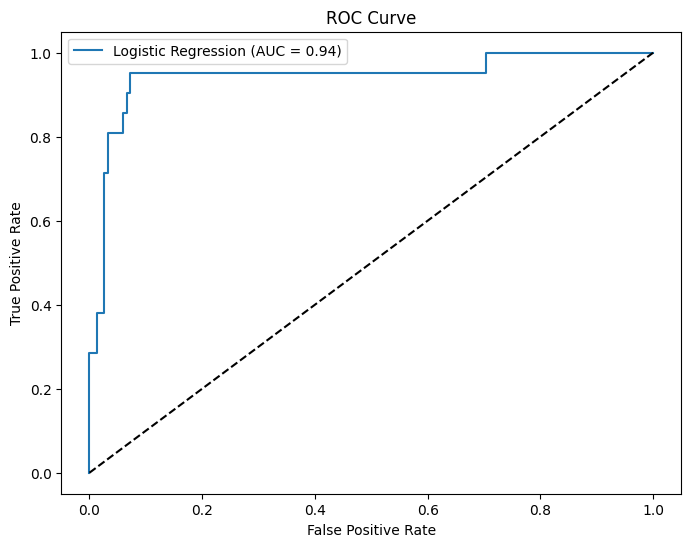

In [250]:
# Predictions and probabilities
y_test_pred =best_log_reg.predict(X_test)
y_test_proba = best_log_reg.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_test_pred))

# ROC-AUC Curve
roc_auc = roc_auc_score(y_test, y_test_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Best Hyperparameters: {'var_smoothing': 1e-05}
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       152
           1       0.45      0.90      0.60        21

    accuracy                           0.86       173
   macro avg       0.72      0.88      0.76       173
weighted avg       0.92      0.86      0.87       173


Confusion Matrix:
[[129  23]
 [  2  19]]


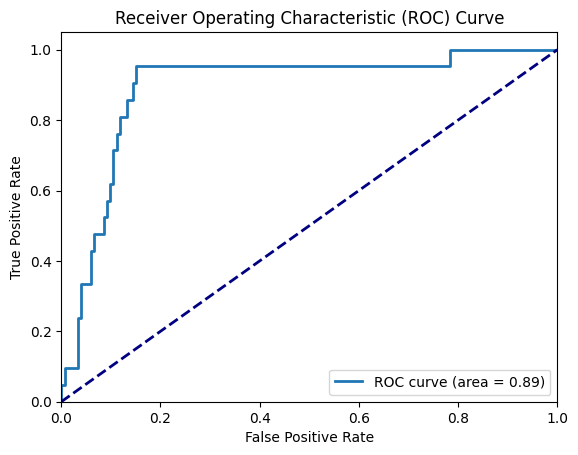

In [251]:
# Initialize the Gaussian Naive Bayes model
nb_model = GaussianNB()

# Define the parameter grid for Naive Bayes (we'll focus on 'var_smoothing')
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
}

# Initialize GridSearchCV with Naive Bayes model
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model and hyperparameters
best_nb_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Generate predictions using the best model
y_pred = best_nb_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC Curve plotting
y_prob = best_nb_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
